In [2]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pickle

In [3]:
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
print("Loaded graph")

Loaded graph


In [4]:
print("Sample node data: ")
print(graph.nodes[0])

Sample node data: 
{'boundary_node': False, 'area': 58376433.4607846, 'STATEFP10': '42', 'COUNTYFP10': '039', 'VTDST10': '60', 'GEOID10': '42039060', 'VTDI10': 'A', 'NAME10': 'CAMBRIDGE SPRINGS Voting District', 'NAMELSAD10': 'CAMBRIDGE SPRINGS Voting District', 'LSAD10': '00', 'MTFCC10': 'G5240', 'FUNCSTAT10': 'N', 'ALAND10': 2258229, 'AWATER10': 0, 'INTPTLAT10': '+41.8018353', 'INTPTLON10': '-080.0596566', 'ATG12D': 0.0, 'ATG12R': 0.0, 'GOV10D': 0.0, 'GOV10R': 0.0, 'PRES12D': 0.0, 'PRES12O': 0.0, 'PRES12R': 0.0, 'SEN10D': 0.0, 'SEN10R': 0.0, 'T16ATGD': 0.0, 'T16ATGR': 0.0, 'T16PRESD': 0.0, 'T16PRESOTH': 0.0, 'T16PRESR': 0.0, 'T16SEND': 0.0, 'T16SENR': 0.0, 'USS12D': 0.0, 'USS12R': 0.0, 'GOV': 3, 'TS': 5, 'HISP_POP': 0, 'TOT_POP': 0, 'WHITE_POP': 0, 'BLACK_POP': 0, 'NATIVE_POP': 0, 'ASIAN_POP': 0, 'F2014GOVD': 0, 'F2014GOVR': 0, '2011_PLA_1': 3, 'REMEDIAL_P': 14, '538CPCT__1': '03', '538DEM_PL': '03', '538GOP_PL': '03', '8THGRADE_1': '1', 'geometry': <shapely.geometry.polygon.Polygon 

In [5]:
my_updaters = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "BVAP": updaters.Tally("BLACK_POP", alias="BVAP"),
    "VAP": updaters.Tally("TOT_POP", alias="VAP")
}
initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)
dict_BVAP = {d : float(sum(
    [graph.nodes[n]["BLACK_POP"] for n in initial_partition.parts[d]]))/float(sum(
    [graph.nodes[n]["TOT_POP"] for n in initial_partition.parts[d]])) for d in initial_partition.parts}

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [6]:
BVAPS = []
counter = 0
for sample in range(0,3000):
    counter += 1
    if counter % 50 == 0:
        print(counter, end=" ")
    district = tree.bipartition_tree(graph, "TOT_POP", ideal_population, 0.02, 2)
    BVAP = sum([graph.nodes[n]["BLACK_POP"] for n in district])
    VAP = sum([graph.nodes[n]["TOT_POP"] for n in district])
    BVAPS.append(BVAP/VAP)

50 100 150 200 250 300 350 400 

NetworkXError: Input is not a correct NetworkX graph.

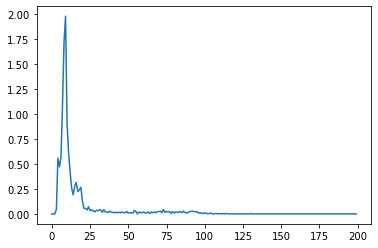

In [8]:
pdf = pickle.load(open("pdf_PA_BVAP.p", "rb"))
n_bins = len(pdf)
plt.plot(pdf)

In [9]:
class BVAP_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

BVAPPDF = BVAP_pdf()

In [10]:
###MCMC time
vector = list(dict_BVAP.values())
print("Starting vector: ", vector)

list_of_vector_dicts = []
counter = 0 
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = BVAPPDF._pdf(proposal[0])*BVAPPDF._pdf(proposal[1])/(BVAPPDF._pdf(vector[position1])*BVAPPDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.04486926398104869, 0.03105268517889877, 0.028254804270462633, 0.020225113052274913, 0.036755774581212645, 0.040445916727828136, 0.045266374988477055, 0.033312124746170055, 0.07336725858724133, 0.023413005934713897, 0.030538123449518007, 0.05137649059620988, 0.04800108917936791, 0.05669159196462904, 0.2147489957847053, 0.17113362873531263, 0.5893275933166027, 0.34225497032262453]


/Users/bhushansuwal/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [11]:
df_real = pd.read_csv("./PA_BPOP/BPOP_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv("./PA_BPOP/BPOP_{0}.csv".format(x), header=None)], ignore_index=True)

Done generating simulated boxplot...
Done generating real boxplot...


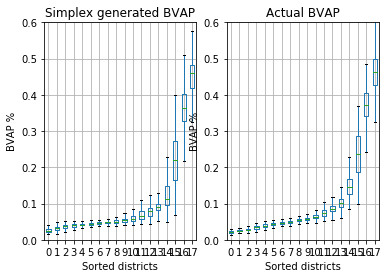

In [12]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated BVAP")
ax.set_ylabel("BVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual BVAP")
ax2.set_ylabel("BVAP %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 0.6)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_PA.png")

In [20]:
# State-dependent variables
state = "PA"
num_districts = 18
dest_folder = "./plots/"

In [14]:
# The following code calculates the BVAP % in each district and sorts them into a list
# The initial_partition is the enacted plan we think
# dict_BVAP is BVAP percents that thomas stored in dictionary (BVAP% = BVAP/VAP)

dict_BVAP_list = sorted(dict_BVAP.values())

# find the gap between each district
enacted_gaps = []
for i in range(num_districts-1):
    enacted_gaps.append(dict_BVAP_list[i+1] - dict_BVAP_list[i])

In [16]:
""" Generate the complementary cdfs
"""
df_simulated = df

# first, get the gaps loaded into a df
def get_dataframe_of_gaps(num_gaps_in_row, df):
    # Make a dataframe of gaps for the real data
    all_gaps = [] 

    for index, row in df.iterrows():
        gaps = dict()
        for j in range(num_gaps_in_row):
            gaps[j] = row[j+1] - row[j]
        all_gaps.append(gaps)

    return pd.DataFrame(all_gaps)

def get_complementary_cdfs(df, num_districts, xs):
    num_rows = len(df.index)

    # list of lists where list at index 0 is the complementary cdf of the first district
    complementary_cdfs = [[] for i in range(num_districts-1)]
    for x in xs:
        for i in range(num_districts-1):
            complementary_cdfs[i].append(len(df[df[i] > x][i])/num_rows)       
    
    return complementary_cdfs
            

gaps_real_df = get_dataframe_of_gaps(num_districts-1, df_real)
gaps_simulated_df = get_dataframe_of_gaps(num_districts-1, df_simulated)

xs = np.linspace(0.0, 0.2, num=200)
real_complementary_cdfs = get_complementary_cdfs(gaps_real_df, num_districts, xs)
simulated_complementary_cdfs = get_complementary_cdfs(gaps_simulated_df, num_districts, xs)

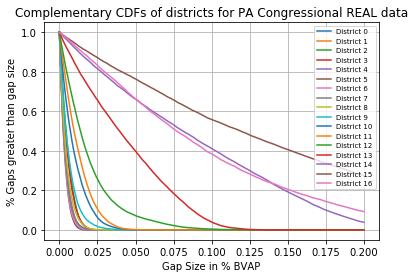

<Figure size 36000x18000 with 0 Axes>

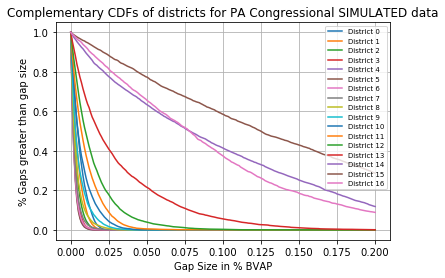

<Figure size 36000x18000 with 0 Axes>

In [21]:
""" Plot the complementary cdfs
"""

def plot_complementary_cdfs(complementary_cdfs, state, dtype, dest_folder):
    fig = plt.figure()
    legend_strs = []
    for i in range(num_districts-1):
        plt.plot(xs, complementary_cdfs[i])
        legend_strs.append("District "+ str(i))

    # plt.clf()
    plt.xlabel("Gap Size in % BVAP")
    plt.ylabel("% Gaps greater than gap size")
    plt.title("Complementary CDFs of districts for "+ state + " Congressional " + dtype + " data")
    plt.legend(legend_strs)
    plt.grid()
    params = {'legend.fontsize': 7,
              'legend.handlelength': 2}
    plt.rcParams.update(params)
    plt.figure(figsize=(120, 60), dpi=300) # doesnt save a high resolution image

    # plt.show()
    fig.savefig(dest_folder+ "cdf_" + state +"_" + dtype + ".png") 
    
plot_complementary_cdfs(real_complementary_cdfs, state, "REAL", dest_folder)
plot_complementary_cdfs(simulated_complementary_cdfs, state, "SIMULATED", dest_folder)

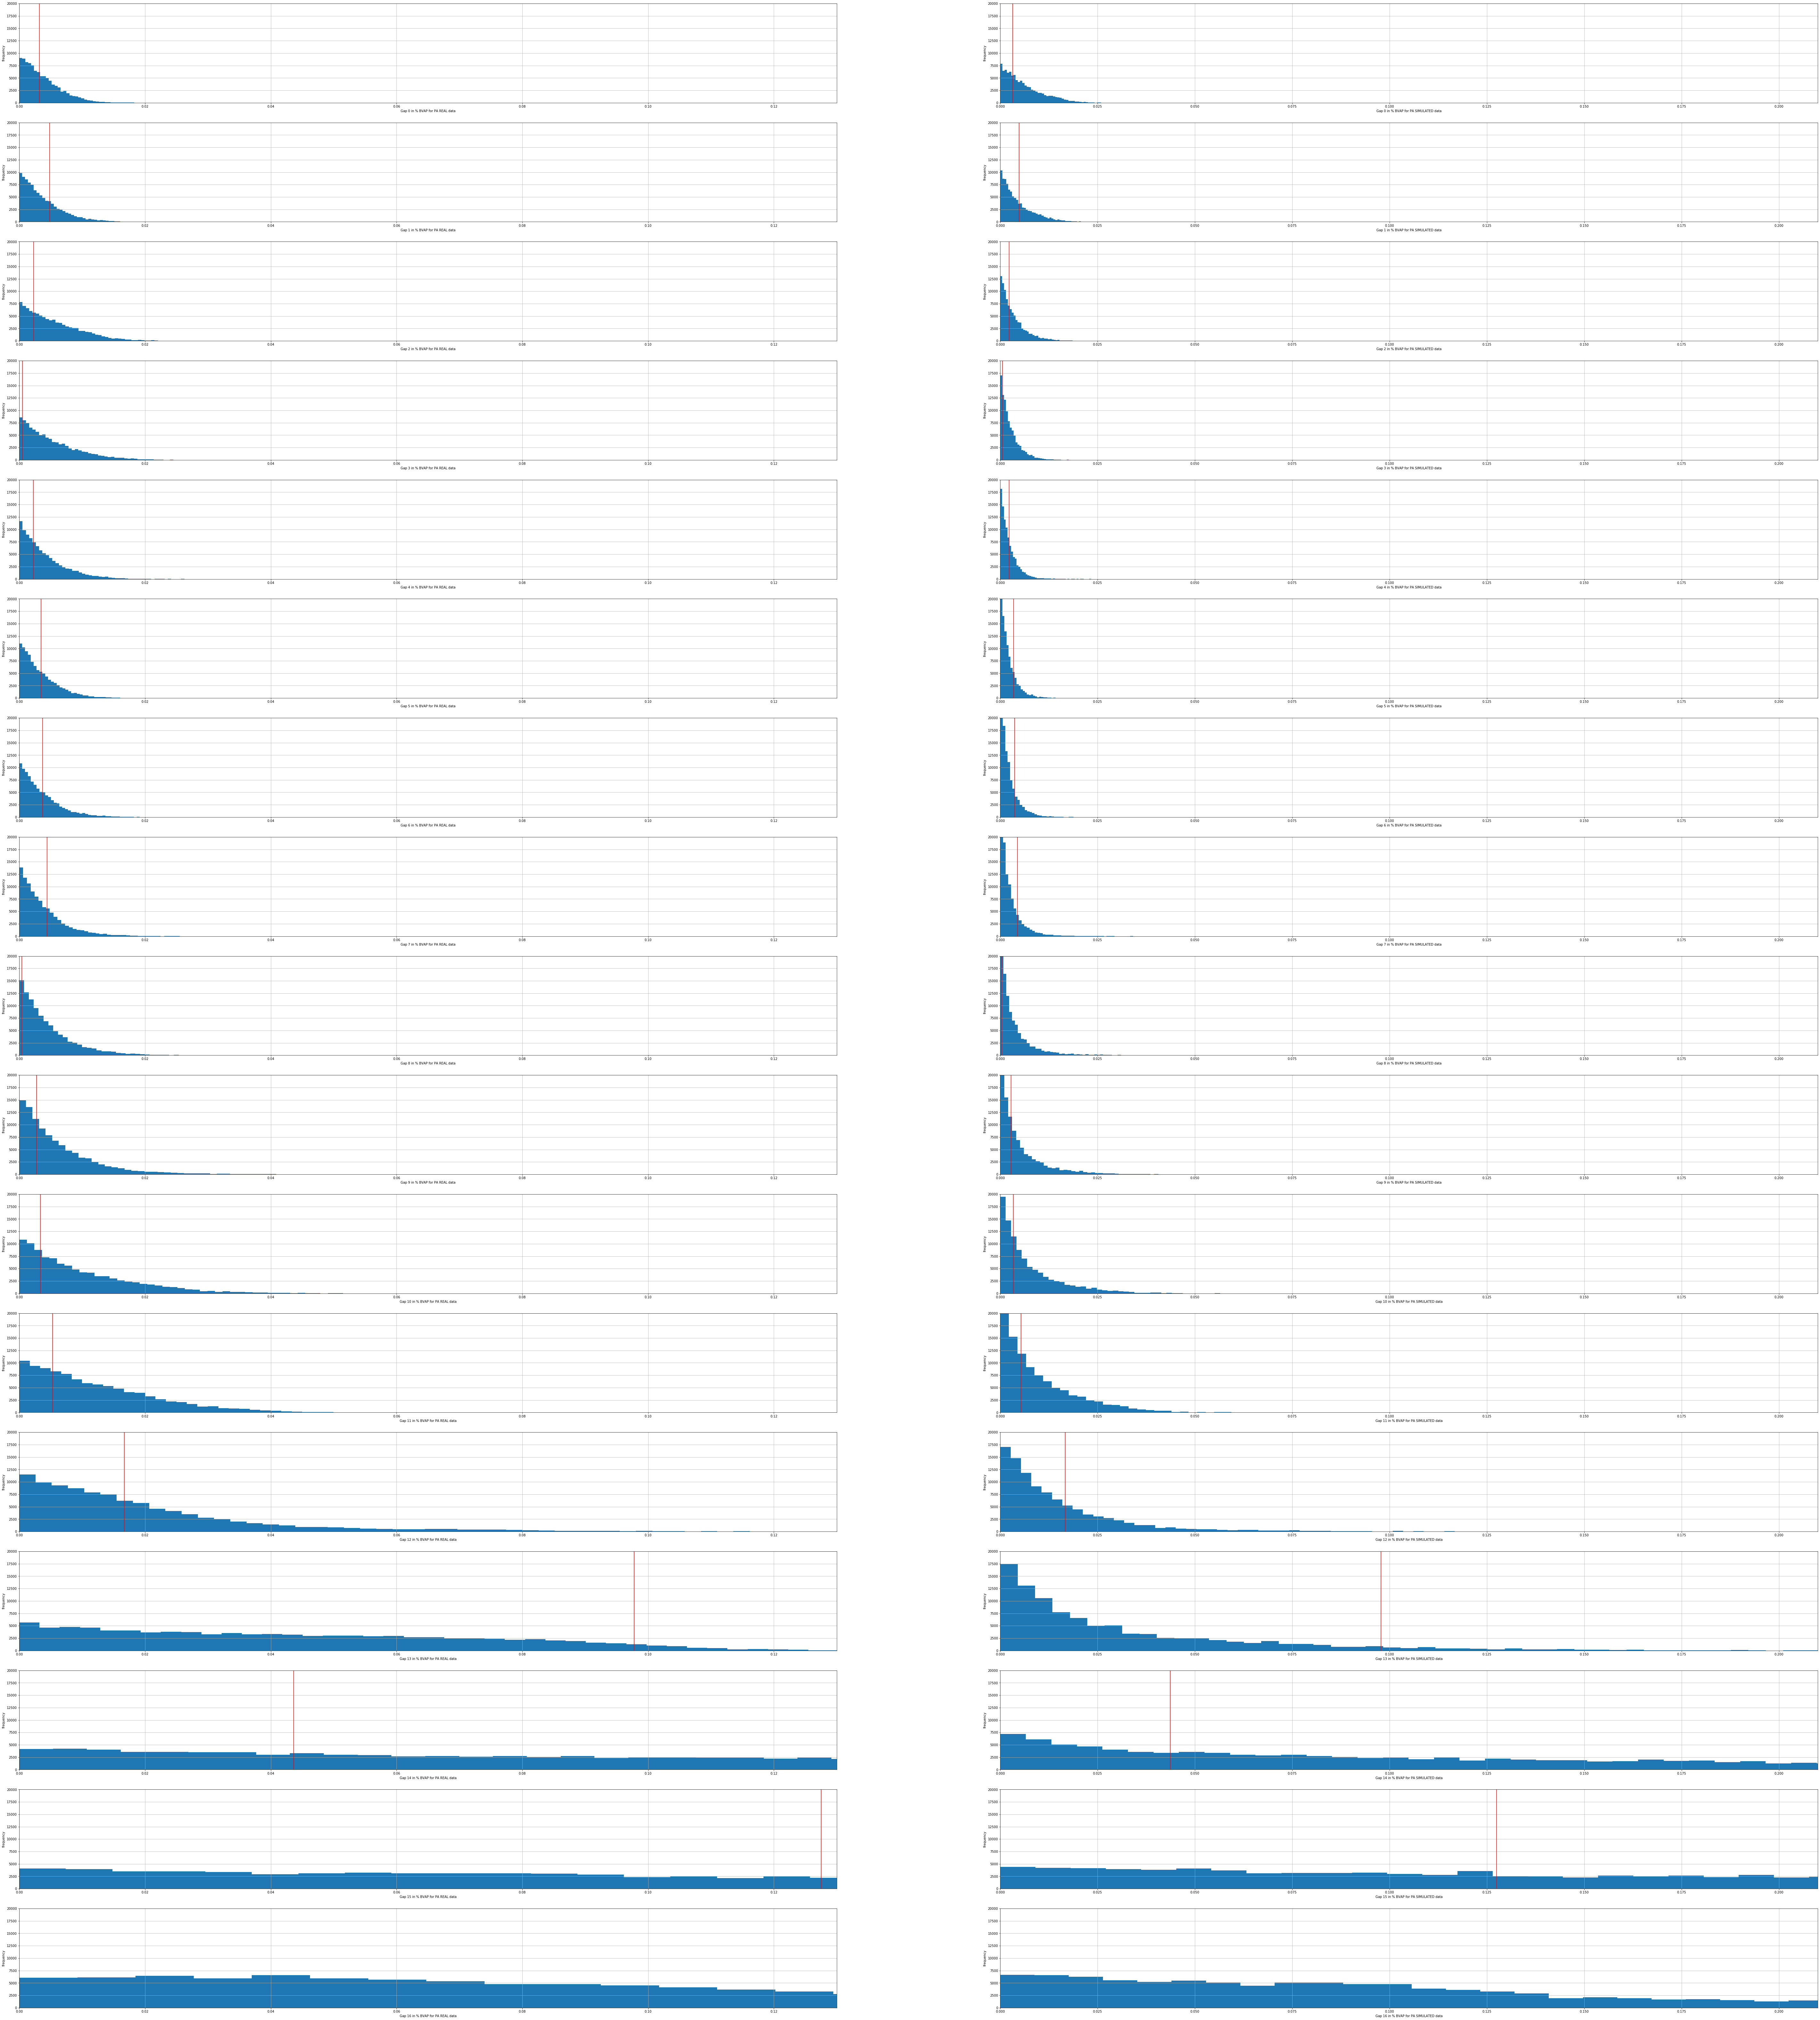

In [24]:
# Plot the gaps for real and simulated
fig = plt.figure(figsize=(20, 11))

index = 0
for i in range(1, num_districts):
    index += 1
    plt.subplot(num_districts-1, 2, index, ylim=(0,20000), xlim=(0, 0.13), 
                xlabel="Gap " + str(i-1) + " in % BVAP for " + state + " REAL data", 
                ylabel="frequency")
    plt.axvline(x=enacted_gaps[i-1], color="red")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=8, wspace=None, hspace=None)
    ax = gaps_real_df[i-1].hist(bins = 50)
    
    index += 1
    plt.subplot(num_districts-1, 2, index, ylim=(0,20000), xlim=(0, 0.21), 
                xlabel="Gap " + str(i-1) + " in % BVAP for " + state + " SIMULATED data", 
                ylabel="frequency")
    plt.axvline(x=enacted_gaps[i-1], color="red")
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=8, wspace=None, hspace=None)
    ax = gaps_simulated_df[i-1].hist(bins = 50)
    
plt.savefig(dest_folder + state + "_hists.png", bbox_inches = 'tight')

In [23]:
enacted_gaps

[0.003187892882438984,
 0.004841798335748736,
 0.0022833191790553736,
 0.0005145617293807643,
 0.002259439567271284,
 0.0034436498350425906,
 0.003690142146615491,
 0.004423347253220557,
 0.0003971110074283621,
 0.002734714190890858,
 0.003375401416841964,
 0.005315101368419166,
 0.016675666622612287,
 0.0977663701480713,
 0.04361536704939267,
 0.12750597453791923,
 0.24707262299397814]